In [9]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from layers.py
from IPython.display import clear_output
from tqdm.auto import tqdm
import sys

#### Imported and... ¡ Here we go ! 

#### Start with data import:

In [ ]:
# Here'll descripted some study notes for me:

transform = transforms.Compose([  # Composes several transforms together
                       transforms.ToTensor(), # Converts numpy ndarray or image to torch.Tensor type
                       transforms.Normalize((0.1307,), (0.3081,)) # Returns normilized images with mean & std (inputs)
                    ])

train_dataset = MNIST('.', train=True, download=True, transform=transform) # MNIST train dataset
test_dataset = MNIST('.', train=False, transform=transform) # MNIST test dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # MNIST train dataloader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # MNIST test dataloader

#### Loaded, checkpoint:

In [13]:
len(train_loader) # Num of batches in train

1875

In [14]:
len(test_loader) # Num of batches in test

313

In [6]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

In [11]:
X.shape # Batch_size, num_channels, x_size, y_size

(32, 1, 28, 28)

In [12]:
y.shape # labels for batch_size

(32,)

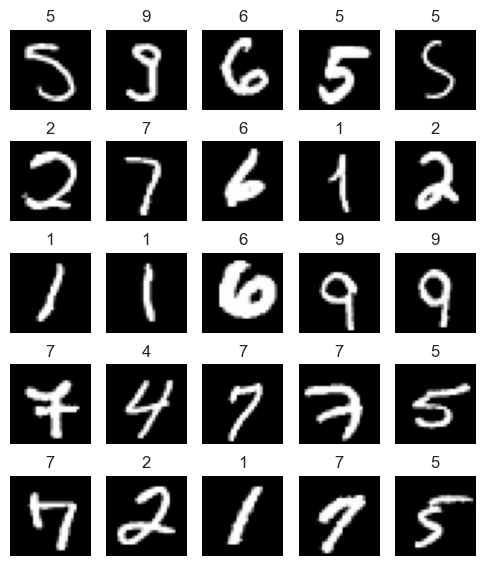

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

#### Works correctly

#### **$I$ Part** -> Classic MNIST with 784-100-100-10 layers and sigmoid activations.

In [17]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    
    # Model's loss
    loss = loss or NLLLoss()

    # Data for plots after training (test and train)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    
    try:
        for epoch in range(epochs):
            
            # Training part

            losses = []
            accuracies = []

            for X, y in train_loader:
                
                # Data prcoessing for NN input
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)

                # Evaluates Negative Log Likelihood Loss for Multi-Classification problem
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)

                # Compute and return DL/dx
                dLdx = loss.backward()

                # Compute gradients
                network.backward(dLdx)

                # Update weights
                network.step(learning_rate)

                accuracies.append((np.argmax(prediction, 1)==y).mean())

            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            # Test part

            losses = []
            accuracies = []  

            for X, y in test_loader:
                
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)

            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()

    except KeyboardInterrupt:
        pass
    
    # Returns all data

    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

#### Then, build and train model:

In [18]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.301/0.294	Accuracy: 0.921/0.920

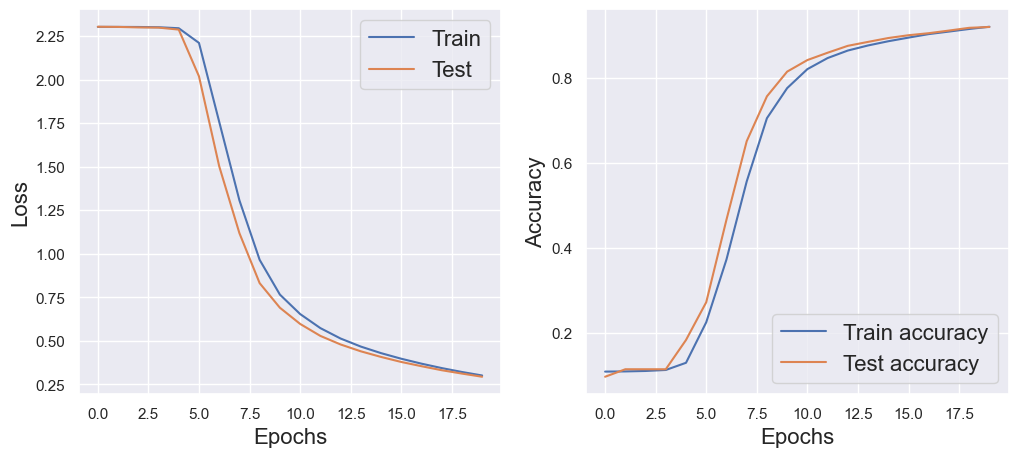

In [19]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

#### Model trained well. Without remarkable overfitting, I guess

#### **$II$ part** -> Try another non-linear activations: ReLU and ELU

#### 1. Rectified Linear Unit:

#### $ReLU(z) = max(0, z)$ 

![ReLU plots](pictures_and_plots/relu_pic.png)

In [21]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

#### Train model with ReLU:

Epoch 19... (Train/Test) NLL: 0.033/0.084	Accuracy: 0.991/0.976

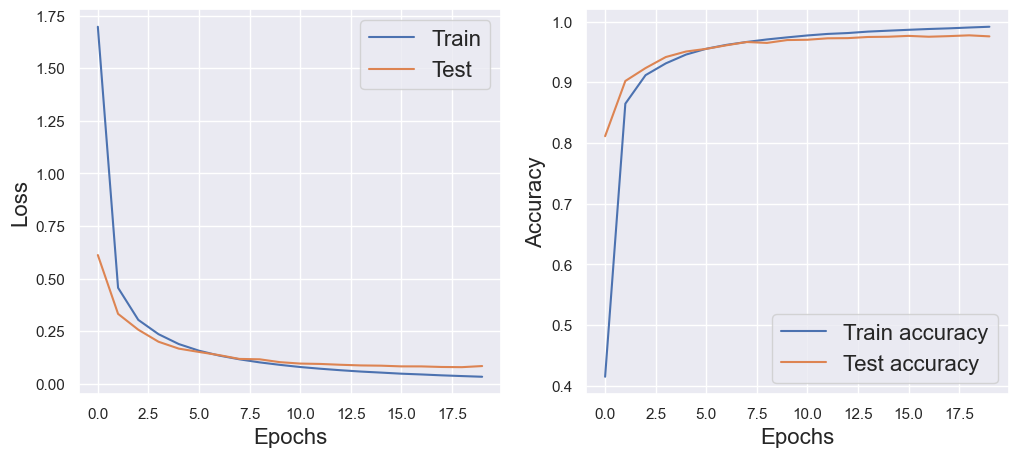

In [42]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

#### __Conclusion__: Weights converged faster with ReLU layer's activation.

#### 2. Exponential Linear Unit:

$$
\text{ELU}(x) =
\begin{cases}
x & \text{if } x \geq 0 \\
\alpha (\exp(x) - 1) & \text{if } x < 0
\end{cases}
$$

#### $\alpha$ - hyperparameter which controls value for negative inputs

![ELU plots](./pictures_and_plots/elu_pic.png)

In [24]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.045/0.078	Accuracy: 0.987/0.975

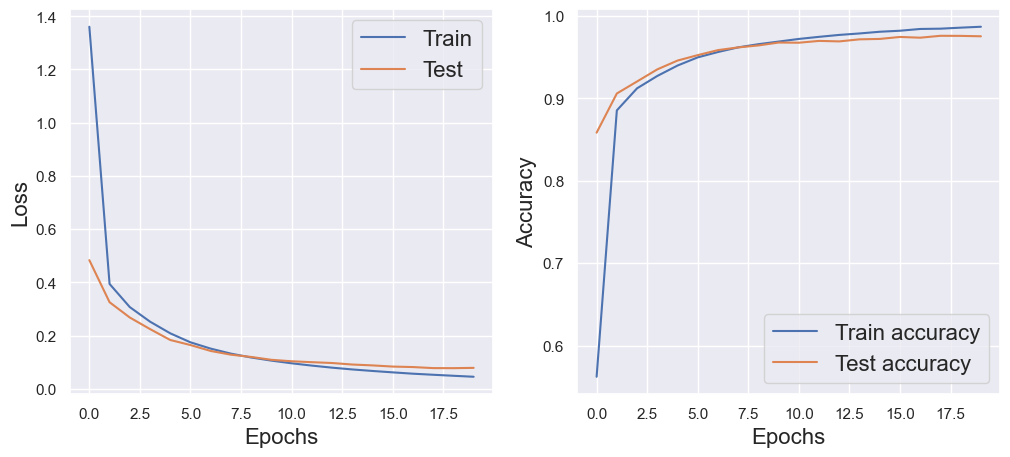

In [26]:
network = NeuralNetwork([Linear(784, 100), ELU(), # 28*28
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

#### __Conclusion__: Weights converged faster with ELU.

#### Final comparison:

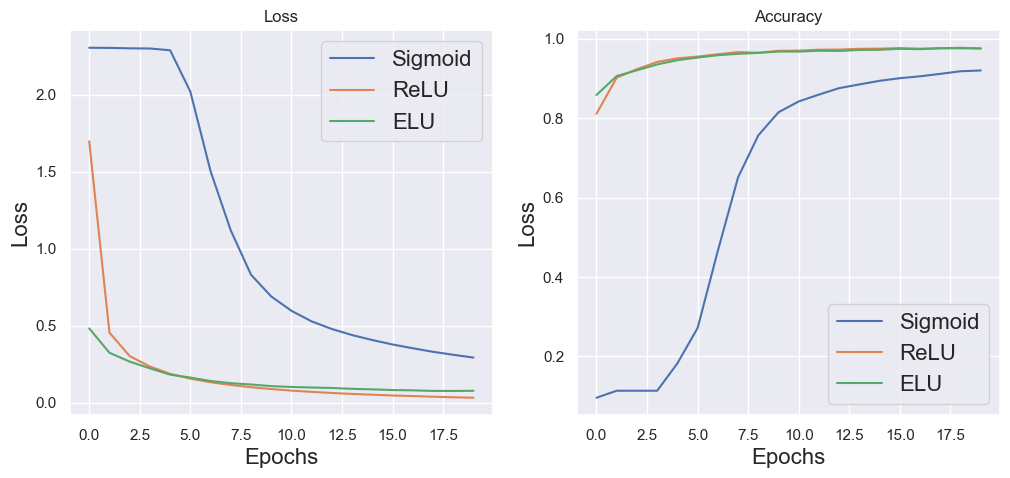

In [44]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(tr_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.show()

#### __Final Conclusion__: ReLU & ELU've converged faster than Sigmoid did. Also Sigmoid hasn't achieved ReLU & ELU results (Loss and accuracy plots)

#### **$HW_{1}$** -> Implement $tanh(z)$

#### $tanh(z) = \frac{2}{1 + e^{-2z}} - 1 = \frac{e^{z} - e^{-z}}{e^{z} + e^{-z}} = \frac{e^{2z} - 1}{e^{2z} + 1}$ - hyperbolic tangent

#### $\frac{\partial tanh(z)}{\partial z} = 1 - tanh^{2}(z)$ - derivative

![TanH plots](./pictures_and_plots/tanh_pic.png)

In [107]:
class TanH:
    def __init__(self):
        pass
    
    @staticmethod
    def tanh_calc(X):
        '''
        Calcualtes and returns tanh(x) 
        '''
        tanh_result = (np.exp(2*X) - 1) / (np.exp(2*X) + 1)
        return tanh_result
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N - batch_size, d - flatten image (28*28))
        '''
        self.X = X
        tanh_result = self.tanh_calc(X)
        return tanh_result


    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        derivative = 1 - self.tanh_calc(self.X) ** 2
        return derivative*dLdy

    def step(self, learning_rate):
        pass

#### Let's try train model with $tanh(x)$ activation:

Epoch 19... (Train/Test) NLL: 0.029/0.076	Accuracy: 0.994/0.977

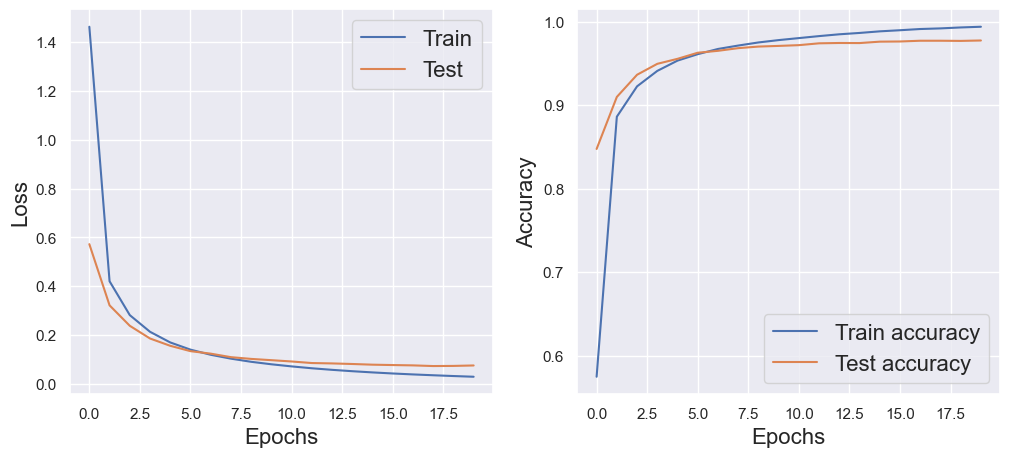

In [108]:
network = NeuralNetwork([Linear(784, 100), TanH(), # 28*28
               Linear(100, 100), TanH(),
               Linear(100, 10)])
loss = NLLLoss()
tr_tanh, ts_tanh, tr_ac_tanh, ts_ac_tanh = train(network, 20, 0.01, plot=True, verbose=True)

#### Well, pretty good results -> Converges fast and really converges. Plots:

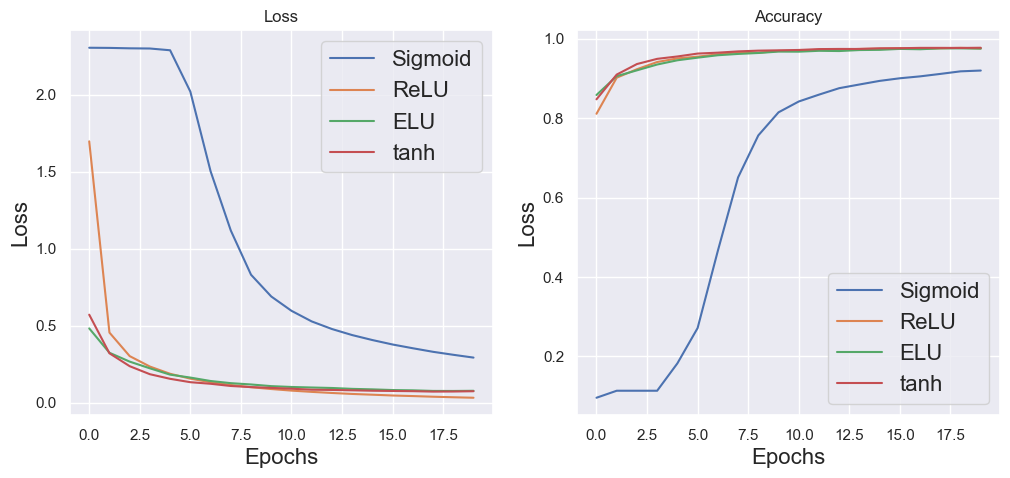

In [110]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(tr_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.plot(ts_tanh, label = 'tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.plot(ts_ac_tanh, label = 'tanh')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.show()

#### Errors analysis:

In [111]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

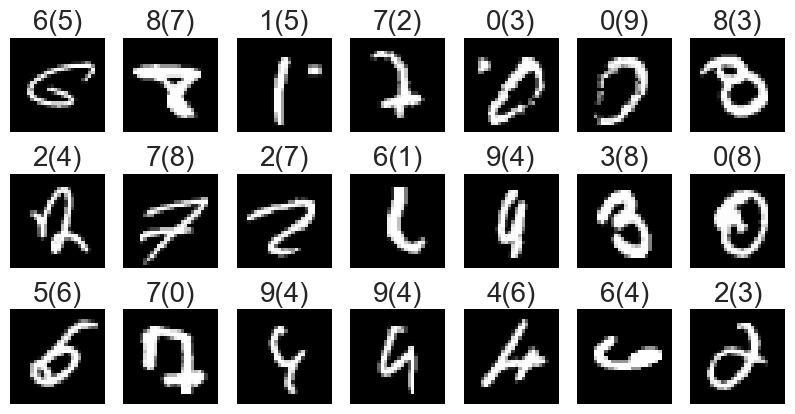

In [112]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

#### **$HW_{2}$** -> Data Augmentation Implementation (tomorrow)